# Adaptive filtering on Steinmetz data using Python

## Notes

### References

- Original Steinmetz paper: https://www.nature.com/articles/s41586-019-1787-x
- `padasip` library: https://github.com/matousc89/padasip
- `padasip` documentation: http://matousc89.github.io/padasip/
- Python adaptive filtering with `padasip`: https://github.com/matousc89/Python-Adaptive-Signal-Processing-Handbook/blob/master/notebooks/adaptive_filters_realtime.ipynb


### Question: How to run adaptive filters on multidimensional data?

- Talked to Josue; he says he doesn't know of any lit off top of head
- Searched online; all implementations were 1D

## Imports

In [1]:
import os
import time

import requests
import numpy as np
import padasip as pa
from matplotlib import pyplot as plt

## Data retrieval

(Copied from `load_steinmetz_decisions.ipynb`. Clean this up eventually.)

In [2]:
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

## Data loading

(Also copied from `load_steinmetz_decisions.ipynb`.)

In [3]:
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


## Compute population avg. firing rate

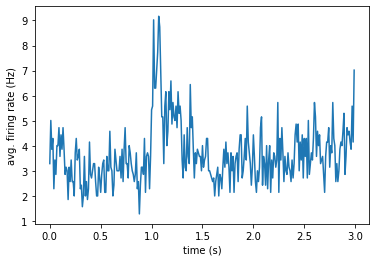

In [4]:
# Number of data points to plot
tmax_plot = 300

# Compute average
n_neurons = dat['spks'].shape[0]
bin_size = dat['bin_size']
spks_all_sessions = dat['spks'].reshape(n_neurons, -1)
fr_avg = np.mean(spks_all_sessions, 0) / bin_size

# Plot first part of signal
tvals_plot = bin_size * np.arange(tmax_plot)
fig, ax = plt.subplots()
plt.plot(tvals_plot, fr_avg[0:tmax_plot])
ax.set(xlabel='time (s)', ylabel='avg. firing rate (Hz)');

## LMS implementation

In [5]:
def lms_filter(x, d, p, mu):
    """Run least mean squares (LMS) filter on input and desired signal.
    
    Args:
        x (N*1 ndarray): Input signal
        d (N*1 ndarray): Desired signal
        p (int): Order of filter
        mu (float): Learning rate
        
    Returns:
        N*1 ndarray: Filter result
        N*p ndarray: Filter weights at each step
        N*1 ndarray: Error
    """
    
    n_smps = x.shape[0]
    
    x_aug = np.concatenate([np.zeros(p), x])
    wts = np.zeros((n_smps, p))
    y = np.zeros(n_smps)
    err = np.zeros(n_smps)
    
    for n in range(n_smps - 1):
        
        x_n = x_aug[n + p:n:-1]
        y[n] = wts[n, :] @ x_n
        err[n] = d[n] - y[n]
        
        wts[n + 1, :] = wts[n, :] + mu * err[n] * x_n
        
    x_last = x_aug[n_smps - 1 + p:n_smps - 1:-1]
    y[-1] = wts[-1, :] @ x_last
    err[-1] = d[-1] - y[-1]
    
    return y, wts, err

## Run handwritten LMS filter on average firing rate signal

In [6]:
%%time

# Goal of filter is to predict next point from previous points
x = fr_avg[0:-1]
d = fr_avg[1:]

y, wts, err = lms_filter(x, d, 20, 0.001)

CPU times: user 404 ms, sys: 5.02 ms, total: 409 ms
Wall time: 413 ms


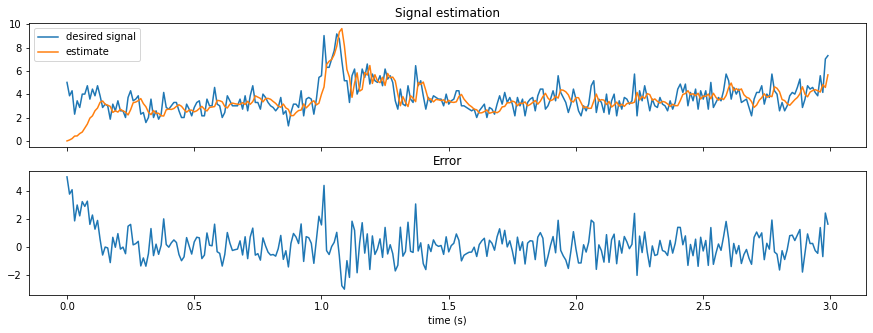

In [7]:
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

ax_1.plot(tvals_plot, d[0:tmax_plot])
ax_1.plot(tvals_plot, y[0:tmax_plot])
ax_1.set_title('Signal estimation')
ax_1.legend(['desired signal', 'estimate'])

ax_2.plot(tvals_plot, err[0:tmax_plot])
ax_2.set_title('Error')
ax_2.set_xlabel('time (s)');

## Measure computation time of filter as function of number of time points

In [8]:
n_trials = 20
k_vals = [10000, 20000, 30000, 40000, 50000, 60000, 70000]

p = 20
mu = 0.001

nk = len(k_vals)
time_vals_ms = np.zeros((nk, n_trials))

for a in range(nk):
    
    k = k_vals[a]
    xk = fr_avg[0:k]
    dk = fr_avg[1:k + 1]

    for b in range(n_trials):
        
        t_start = time.perf_counter()
        _, _, _ = lms_filter(xk, dk, p, mu)
        t_end = time.perf_counter()
        
        time_vals_ms[a, b] = (t_end - t_start) * 1000

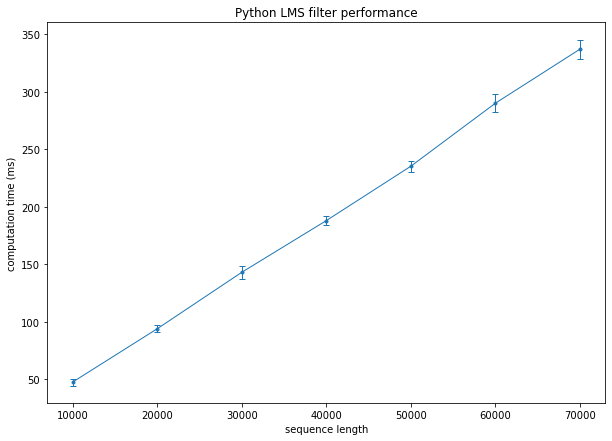

In [28]:
time_mean = np.mean(time_vals_ms, 1)
time_std = np.std(time_vals_ms, 1)

fig, ax = plt.subplots(figsize=(10, 7))
err = np.std(time_vals_ms, 1)
ax.errorbar(k_vals, time_mean, yerr=err, fmt='.-', linewidth=1.0, capsize=3.0)
ax.set(xlabel='sequence length', ylabel='computation time (ms)')
ax.set_title('Python LMS filter performance')

plt.savefig('/Users/cmcgrory/park_lab/realtime/lms_python.png');